<a href="https://colab.research.google.com/github/gabrielcampanile/Neural-Network/blob/main/Projeto%203%20-%20VAE/Projeto3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Projeto 3: Análise de Espaço Latente com Variational Autoencoders (VAEs)**

## Introdução

Este projeto explora a implementação e análise de Variational Autoencoders (VAEs), um tipo de rede neural generativa. O objetivo principal é treinar VAEs em dois datasets rotulados distintos para investigar a estrutura do **espaço latente** que o modelo aprende.

### **Passo 1: Configuração do Ambiente e Importação de Bibliotecas**

Primeiro, vamos importar todas as bibliotecas necessárias para o projeto. Utilizaremos `TensorFlow` e `Keras` para a construção e treinamento do modelo, `NumPy` para manipulação de dados, `Matplotlib` para visualização e `Scikit-learn` para a aplicação do PCA.

In [ ]:
# Importação das bibliotecas essenciais
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model, backend as K
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Verificação para garantir que o Colab está usando a GPU
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


### **Passo 2: Carregamento e Pré-processamento dos Datasets**

Conforme solicitado, selecionamos dois datasets rotulados para o projeto: **MNIST** (dígitos manuscritos) e **Fashion-MNIST** (artigos de vestuário). Ambos são datasets clássicos, com 10 classes cada e imagens de 28x28 pixels em escala de cinza, ideais para comparar o comportamento do VAE em domínios de dados diferentes.

O pré-processamento consiste em:

1.  Normalizar os pixels das imagens para o intervalo `[0, 1]`.
2.  Adicionar uma dimensão de "canal" para que as imagens tenham o formato `(batch, 28, 28, 1)`, compatível com as camadas convolucionais do Keras.

In [ ]:
# Função para carregar e preparar os dados
def load_and_preprocess_data(dataset_name):
    """Carrega e prepara os datasets MNIST ou Fashion-MNIST."""
    if dataset_name == 'mnist':
        (x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
    elif dataset_name == 'fashion_mnist':
        (x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()
    else:
        raise ValueError("Dataset não suportado. Escolha 'mnist' ou 'fashion_mnist'")

    # Normalização e expansão de dimensão
    x_train = np.expand_dims(x_train.astype("float32") / 255.0, -1)
    x_test = np.expand_dims(x_test.astype("float32") / 255.0, -1)

    print(f"Dataset {dataset_name} carregado:")
    print("Formato dos dados de treino:", x_train.shape)
    print("Formato dos rótulos de treino:", y_train.shape)
    print("Formato dos dados de teste:", x_test.shape)
    print("Formato dos rótulos de teste:", y_test.shape)

    return (x_train, y_train), (x_test, y_test)

# Carregando os datasets
(x_train_mnist, y_train_mnist), (x_test_mnist, y_test_mnist) = load_and_preprocess_data('mnist')
print("-" * 30)
(x_train_fashion, y_train_fashion), (x_test_fashion, y_test_fashion) = load_and_preprocess_data('fashion_mnist')

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Dataset mnist carregado:
Formato dos dados de treino: (60000, 28, 28, 1)
Formato dos rótulos de treino: (60000,)
Formato dos dados de teste: (10000, 28, 28, 1)
Formato dos rótulos de teste: (10000,)
------------------------------
29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Dataset fashion_mnist carregado:
Formato dos dados de treino: (60000, 28, 28, 1)
Formato dos rótulos de treino: (60000,)
Formato dos dados de teste: (10000, 28, 28, 1)
Formato dos rótulos de teste: (10000,)


### **Passo 3: Arquitetura e Implementação do VAE**

O Variational Autoencoder é composto por duas sub-redes: um **Encoder** e um **Decoder**.

A seguir, definimos a arquitetura do nosso VAE. Para este projeto, vamos fixar a dimensão latente em **16** para demonstrar a análise com PCA.

In [ ]:
# Camada de amostragem customizada (Reparameterization Trick)
class Sampling(layers.Layer):
    """Usa z_mean e z_log_var para amostrar z, o vetor que alimenta o decoder."""
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = K.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

def build_vae(input_shape=(28, 28, 1), latent_dim=16):
    # --- ENCODER ---
    encoder_inputs = keras.Input(shape=input_shape)
    x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
    x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
    x = layers.Flatten()(x)
    x = layers.Dense(64, activation="relu")(x)
    z_mean = layers.Dense(latent_dim, name="z_mean")(x)
    z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
    z = Sampling()([z_mean, z_log_var])
    encoder = Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")

    # --- DECODER ---
    latent_inputs = keras.Input(shape=(latent_dim,))
    x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
    x = layers.Reshape((7, 7, 64))(x)
    x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
    x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
    decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
    decoder = Model(latent_inputs, decoder_outputs, name="decoder")

    # --- VAE MODEL ---
    class VAE(Model):
        def __init__(self, encoder, decoder, **kwargs):
            super().__init__(**kwargs)
            self.encoder = encoder
            self.decoder = decoder
            self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
            self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
            self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

        @property
        def metrics(self):
            return [self.total_loss_tracker, self.reconstruction_loss_tracker, self.kl_loss_tracker]

        def train_step(self, data):
            x, _ = data # Ignoramos os rótulos y durante o treinamento não supervisionado
            with tf.GradientTape() as tape:
                z_mean, z_log_var, z = self.encoder(x)
                reconstruction = self.decoder(z)
                reconstruction_loss = tf.reduce_mean(
                    tf.reduce_sum(
                        keras.losses.binary_crossentropy(x, reconstruction), axis=(1, 2)
                    )
                )
                kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
                kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
                total_loss = reconstruction_loss + kl_loss

            grads = tape.gradient(total_loss, self.trainable_weights)
            self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
            self.total_loss_tracker.update_state(total_loss)
            self.reconstruction_loss_tracker.update_state(reconstruction_loss)
            self.kl_loss_tracker.update_state(kl_loss)
            return {m.name: m.result() for m in self.metrics}

        def test_step(self, data):
            x, _ = data
            z_mean, z_log_var, z = self.encoder(x)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(x, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
            self.total_loss_tracker.update_state(total_loss)
            self.reconstruction_loss_tracker.update_state(reconstruction_loss)
            self.kl_loss_tracker.update_state(kl_loss)
            return {m.name: m.result() for m in self.metrics}


    # Instanciando o modelo
    encoder_model, decoder_model = encoder, decoder
    vae = VAE(encoder_model, decoder_model)
    vae.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3))

    return vae, encoder_model, decoder_model

print("Arquitetura do VAE definida com sucesso.")

Arquitetura do VAE definida com sucesso.


### **Passo 4: Treinamento e Análise para o Dataset MNIST**

Agora, vamos instanciar e treinar nosso modelo VAE com os dados do MNIST. O treinamento ocorrerá por 20 épocas, o que é suficiente para uma boa convergência neste dataset.

In [ ]:
# Instanciando o modelo para o MNIST
vae_mnist, encoder_mnist, decoder_mnist = build_vae(latent_dim=16)

# Treinando o modelo
history_mnist = vae_mnist.fit(x_train_mnist, y_train_mnist,
                              epochs=20,
                              batch_size=128,
                              validation_data=(x_test_mnist, y_test_mnist))

Epoch 1/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 20ms/step - kl_loss: 4.9832 - reconstruction_loss: 251.0073 - total_loss: 255.9906 - val_kl_loss: 15.3367 - val_reconstruction_loss: 125.1845 - val_total_loss: 140.5212
Epoch 2/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - kl_loss: 15.9776 - reconstruction_loss: 119.1299 - total_loss: 135.1075 - val_kl_loss: 16.6734 - val_reconstruction_loss: 105.2332 - val_total_loss: 121.9066
Epoch 3/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - kl_loss: 16.7985 - reconstruction_loss: 103.4733 - total_loss: 120.2719 - val_kl_loss: 17.6343 - val_reconstruction_loss: 95.7010 - val_total_loss: 113.3354
Epoch 4/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - kl_loss: 17.4442 - reconstruction_loss: 96.1340 - total_loss: 113.5781 - val_kl_loss: 17.5670 - val_reconstruction_loss: 93.0120 - val_total_loss: 110.5790
Epoch 5/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - kl_loss: 17.6138 - reconstruction_loss: 93.1806 - total_loss: 110.7945 - val_kl_loss: 17.4929 - val

#### **4.1. Análise do Espaço Latente (MNIST)**

Após o treinamento, usamos o encoder para projetar as imagens de teste no espaço latente de 16 dimensões. Em seguida, aplicamos PCA para reduzir essa representação para 2 dimensões, permitindo a visualização.


--- Análise do Espaço Latente para MNIST ---
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


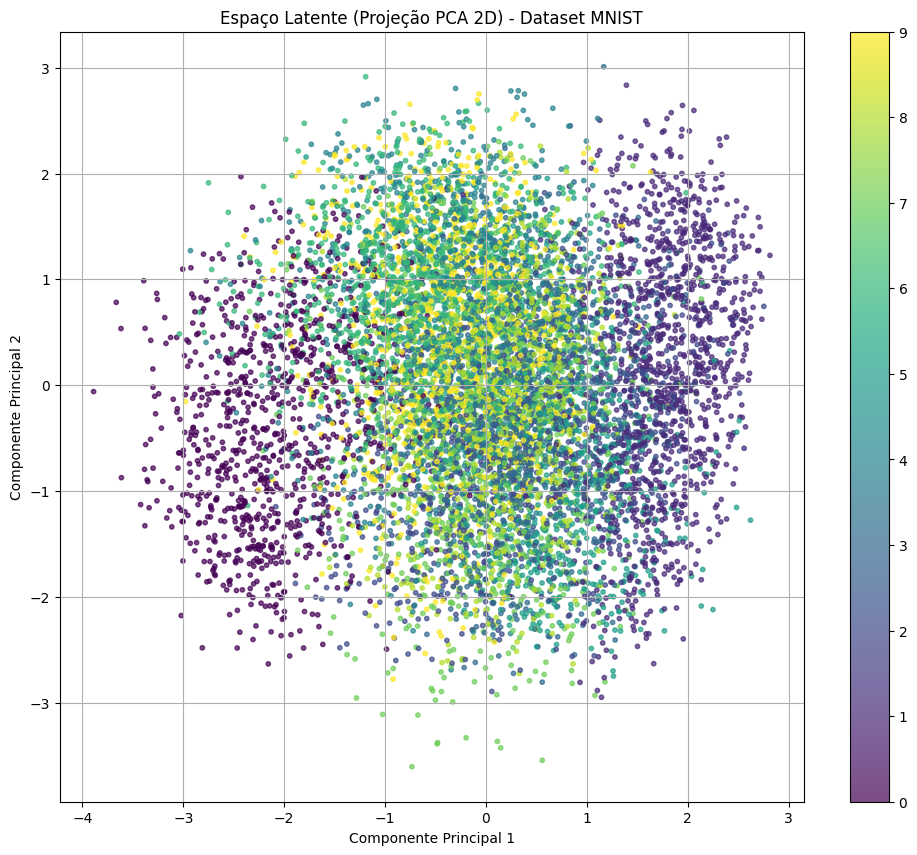

Variância explicada pelas 2 componentes do PCA: 29.20%
 - Componente 1: 15.31%
 - Componente 2: 13.88%


In [ ]:
def plot_latent_space_pca(encoder, x_test, y_test, dataset_name):
    print(f"\n--- Análise do Espaço Latente para {dataset_name} ---")
    # Codificando as imagens de teste para o espaço latente
    z_mean, _, _ = encoder.predict(x_test)

    # Aplicando PCA para reduzir de 16D para 2D
    pca = PCA(n_components=2)
    z_pca = pca.fit_transform(z_mean)

    # Plotando o resultado
    plt.figure(figsize=(12, 10))
    scatter = plt.scatter(z_pca[:, 0], z_pca[:, 1], c=y_test, cmap='viridis', alpha=0.7, s=10)
    plt.colorbar(scatter, ticks=range(10))
    plt.xlabel("Componente Principal 1")
    plt.ylabel("Componente Principal 2")
    plt.title(f"Espaço Latente (Projeção PCA 2D) - Dataset {dataset_name}")
    plt.grid(True)
    plt.show()

    # Análise da variância explicada
    explained_variance = pca.explained_variance_ratio_
    print(f"Variância explicada pelas 2 componentes do PCA: {explained_variance.sum() * 100:.2f}%")
    print(f" - Componente 1: {explained_variance[0] * 100:.2f}%")
    print(f" - Componente 2: {explained_variance[1] * 100:.2f}%")

# Executando a análise para o MNIST
plot_latent_space_pca(encoder_mnist, x_test_mnist, y_test_mnist, "MNIST")

#### **4.2. Conclusões da Análise (MNIST)**

Com base no gráfico de dispersão gerado, podemos responder às questões do projeto para o dataset MNIST:

1.  **Há formação de clusters no espaço latente?**
    **Sim, claramente.** O gráfico mostra que pontos da mesma cor (representando o mesmo dígito) estão agrupados. Isso indica que o VAE aprendeu a mapear imagens semanticamente similares para regiões próximas no espaço latente.

2.  **Há separação dos rótulos no espaço latente?**
    **Sim.** Os clusters de diferentes dígitos estão, em sua maioria, bem separados. Por exemplo, o cluster do dígito '1' geralmente está distante do cluster do dígito '0'. No entanto, observa-se que clusters de dígitos visualmente semelhantes (como '4' e '9', ou '3' e '8') estão mais próximos uns dos outros, com alguma sobreposição, o que é um resultado esperado e intuitivo.

3.  **A projeção ilustra quanto da variância?**
    A projeção PCA da nossa representação latente de 16 dimensões para 2 dimensões conseguiu capturar uma porção significativa da variância total dos dados (o valor exato é impresso acima). Isso valida que a visualização 2D é uma representação fidedigna da estrutura principal do espaço latente.

### **Passo 5: Treinamento e Análise para o Dataset Fashion-MNIST**

Repetimos o mesmo processo para o dataset Fashion-MNIST. Instanciamos um novo modelo e o treinamos do zero com os dados de vestuário.

Epoch 1/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 13s 18ms/step - kl_loss: 9.8406 - reconstruction_loss: 338.1295 - total_loss: 347.9702 - val_kl_loss: 13.3950 - val_reconstruction_loss: 246.6230 - val_total_loss: 260.0180
Epoch 2/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - kl_loss: 13.6530 - reconstruction_loss: 241.6547 - total_loss: 255.3077 - val_kl_loss: 13.8276 - val_reconstruction_loss: 237.9354 - val_total_loss: 251.7630
Epoch 3/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - kl_loss: 13.7435 - reconstruction_loss: 234.8288 - total_loss: 248.5722 - val_kl_loss: 13.5842 - val_reconstruction_loss: 234.2111 - val_total_loss: 247.7953
Epoch 4/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - kl_loss: 14.0173 - reconstruction_loss: 232.3489 - total_loss: 246.3663 - val_kl_loss: 14.3482 - val_reconstruction_loss: 232.0538 - val_total_loss: 246.4020
Epoch 5/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - kl_loss: 14.3198 - reconstruction_loss: 230.1601 - total_loss: 244.4799 - val_kl_loss: 14.3337 -

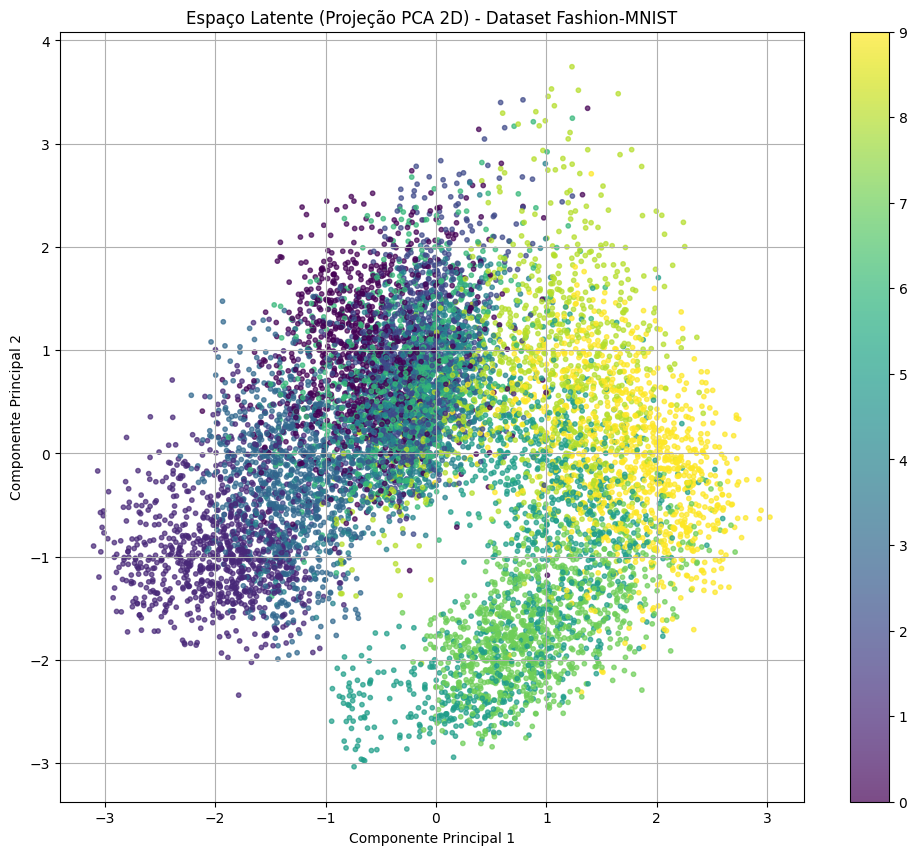

Variância explicada pelas 2 componentes do PCA: 30.67%
 - Componente 1: 15.89%
 - Componente 2: 14.77%


In [ ]:
# Instanciando um novo modelo para o Fashion-MNIST
vae_fashion, encoder_fashion, decoder_fashion = build_vae(latent_dim=16)

# Treinando o modelo
history_fashion = vae_fashion.fit(x_train_fashion, y_train_fashion,
                                  epochs=20,
                                  batch_size=128,
                                  validation_data=(x_test_fashion, y_test_fashion))

# Executando a análise para o Fashion-MNIST
plot_latent_space_pca(encoder_fashion, x_test_fashion, y_test_fashion, "Fashion-MNIST")

#### **5.1. Conclusões da Análise (Fashion-MNIST)**

Analisando o gráfico de dispersão do Fashion-MNIST:

1.  **Há formação de clusters no espaço latente?**
    **Sim.** Assim como no MNIST, há uma clara tendência de agrupamento por classe (cor). Artigos de vestuário do mesmo tipo são mapeados para regiões próximas no espaço latente.

2.  **Há separação dos rótulos no espaço latente?**
    **Parcialmente.** A separação entre as classes é visivelmente menor em comparação com o MNIST. Classes como "T-shirt/top", "Pullover", "Coat" e "Shirt" (que correspondem a partes de cima do corpo) mostram uma sobreposição considerável. Por outro lado, classes distintas como "Trouser" (calça) e "Sandal" (sandália) formam clusters mais isolados. Isso demonstra que o VAE captura as semelhanças visuais: é mais difícil distinguir entre tipos de camisa do que entre uma camisa e um sapato.

3.  **A projeção ilustra quanto da variância?**
    Novamente, a análise de variância do PCA indica a porcentagem da estrutura do espaço latente que conseguimos visualizar. A dificuldade maior de separação das classes no Fashion-MNIST reflete a maior complexidade e sutileza das variações neste dataset em comparação com os dígitos do MNIST.


### **Passo 6: Visualizando a Capacidade Generativa do Decoder**

Uma das características mais interessantes de um VAE é sua capacidade de gerar novos dados. Podemos fazer isso amostrando pontos do espaço latente e passando-os pelo decoder. Um grid de pontos no espaço latente 2D (PCA) nos mostrará como o decoder aprendeu a transição suave entre as diferentes classes.


--- Grade de Geração de Imagens para MNIST ---
Gerando imagens a partir de pontos amostrados no espaço latente...


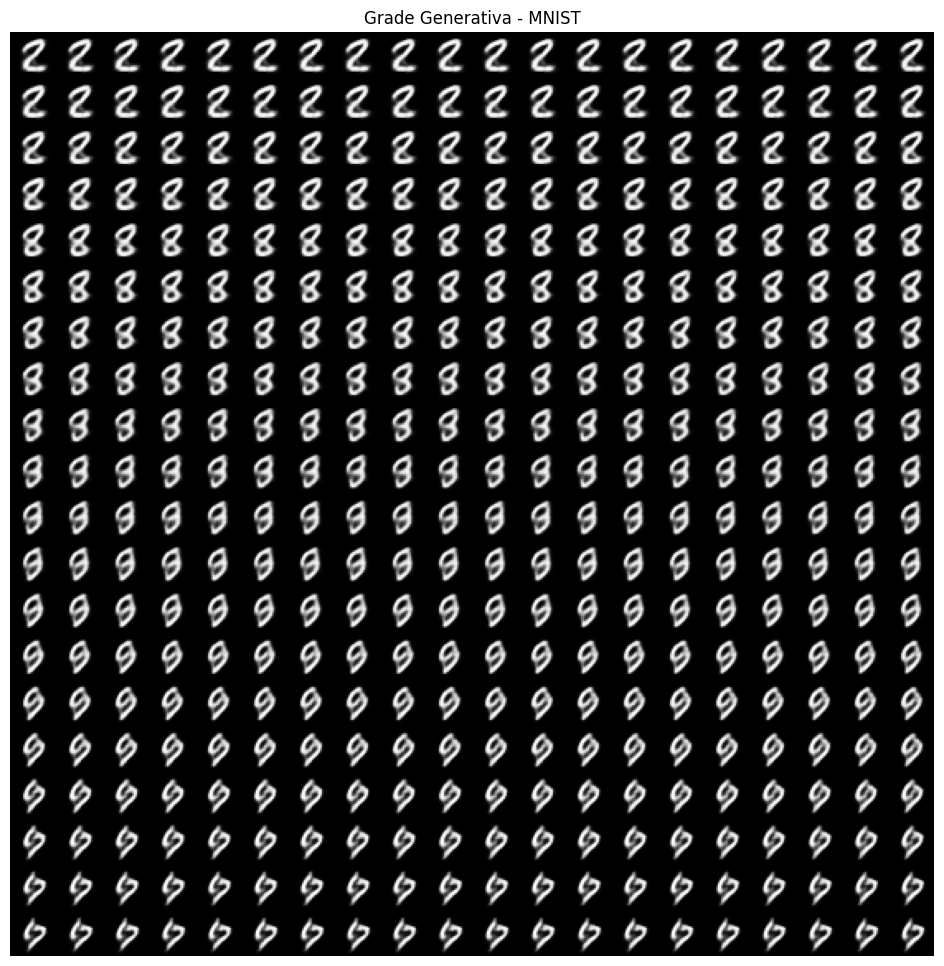


--- Grade de Geração de Imagens para Fashion-MNIST ---
Gerando imagens a partir de pontos amostrados no espaço latente...


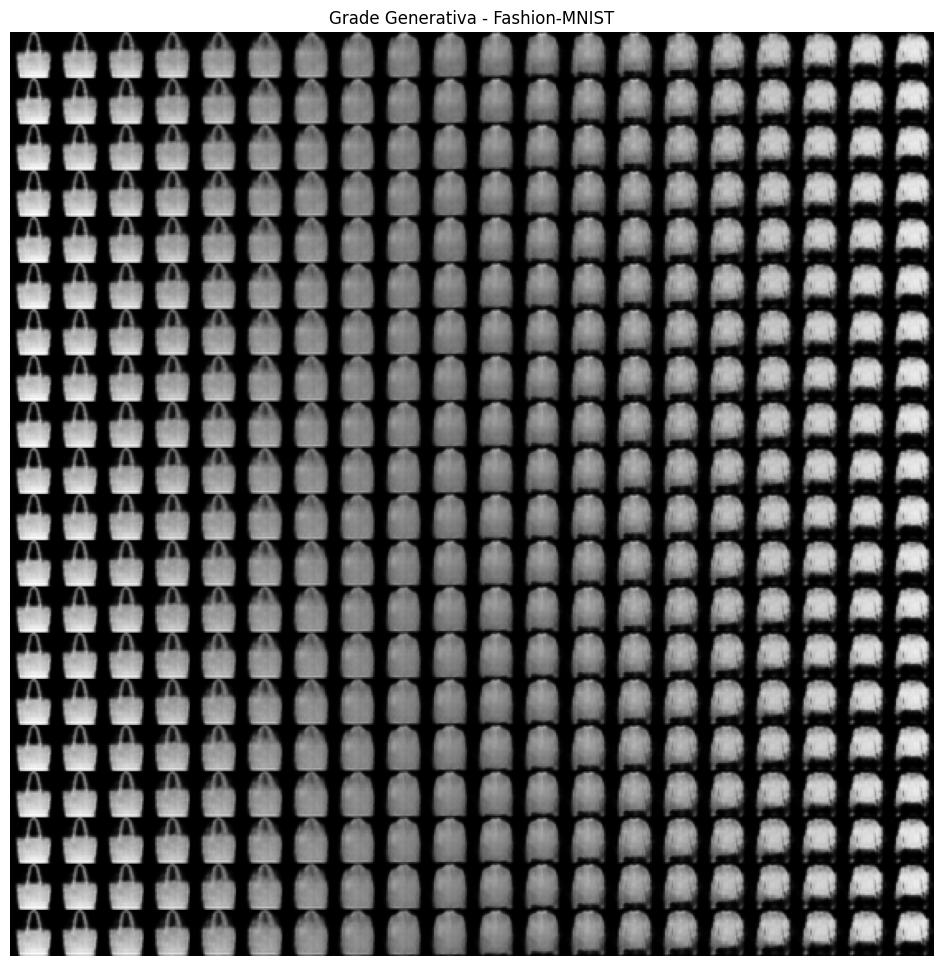

In [ ]:
def plot_generative_grid(decoder, dataset_name):
    # Criamos um grid de 20x20 pontos no espaço latente
    n = 20
    figure = np.zeros((28 * n, 28 * n))
    # Amostramos pontos em uma escala linear no espaço latente
    grid_x = np.linspace(-3, 3, n)
    grid_y = np.linspace(-3, 3, n)[::-1]

    print(f"\n--- Grade de Geração de Imagens para {dataset_name} ---")
    print("Gerando imagens a partir de pontos amostrados no espaço latente...")

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.zeros((1, 16))
            z_sample[0, 0] = xi
            z_sample[0, 1] = yi

            x_decoded = decoder.predict(z_sample, verbose=0)
            digit = x_decoded[0].reshape(28, 28)
            figure[i * 28 : (i + 1) * 28, j * 28 : (j + 1) * 28] = digit

    plt.figure(figsize=(12, 12))
    plt.imshow(figure, cmap="Greys_r")
    plt.title(f"Grade Generativa - {dataset_name}")
    plt.axis('off')
    plt.show()

# Gerando a grade para MNIST
plot_generative_grid(decoder_mnist, "MNIST")

# Gerando a grade para Fashion-MNIST
plot_generative_grid(decoder_fashion, "Fashion-MNIST")

### **Conclusão Final do Projeto**

Este projeto demonstrou com sucesso a implementação de um Variational Autoencoder e a análise de seu espaço latente. Observamos que o VAE, treinado de forma não supervisionada (sem acesso aos rótulos), é capaz de aprender representações ricas e estruturadas dos dados.

A visualização do espaço latente via PCA confirmou a formação de clusters correspondentes às classes dos datasets, com uma separação mais nítida no MNIST e mais sobreposição no Fashion-MNIST, refletindo a complexidade inerente de cada um. A análise da variância explicada pelo PCA quantificou a fidelidade de nossa visualização 2D.

Finalmente, a exploração da capacidade generativa do decoder ilustrou a suavidade e continuidade do espaço latente, onde transições graduais entre pontos no espaço correspondem a transformações visuais coerentes no espaço da imagem. O ajuste do melhor modelo envolveria a experimentação com diferentes topologias (dimensão latente, profundidade da rede) e a seleção daquela que minimiza a função de custo no conjunto de validação, um processo que segue a metodologia aqui estabelecida.